In [ ]:

import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)


device: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt"
assert os.path.exists(DATA_PATH), "경로가 올바른지 확인하세요."


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_wisdm_raw(raw_path):
    rows = []
    with open(raw_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # 콤마/공백 섞여 들어오는 경우가 있어 통합 정규화
            parts = re.split('[, ]+', line)
            if len(parts) < 6:
                continue
            user = parts[0]
            activity = parts[1]
            x = parts[-3]
            y = parts[-2]
            z = parts[-1].replace(';','')
            timestamp = ''.join(parts[2:-3])  # 남은 부분을 timestamp로 묶음
            try:
                rows.append([user, activity, int(timestamp), float(x), float(y), float(z)])
            except:
                # 형식 틀어진 라인은 스킵
                continue
    df = pd.DataFrame(rows, columns=['user','activity','timestamp','x','y','z'])
    df = df.sort_values(['user','activity','timestamp']).reset_index(drop=True)
    return df

df = load_wisdm_raw(DATA_PATH)
print(df.shape)
df


(1086465, 6)


,user,activity,timestamp,x,y,z
0,1,Downstairs,6552942304000,-0.15,9.15,-0.34
1,1,Downstairs,6552992292000,0.11,9.19,2.76
2,1,Downstairs,6553042310000,-4.06,7.40,4.02
3,1,Downstairs,6553092298000,-2.87,7.93,3.21
4,1,Downstairs,6553142347000,-0.19,10.04,4.82
...,...,...,...,...,...,...
1086460,9,Walking,9614392347000,12.37,7.70,3.49
1086461,9,Walking,9614442335000,10.84,6.78,1.14
1086462,9,Walking,9614492292000,8.01,5.05,-0.04
1086463,9,Walking,9614542341000,5.86,4.21,-1.18


In [ ]:
def make_windows_userwise_mode(df: pd.DataFrame, window_size=128, step=32):
    """
    df: columns = ['user','activity','timestamp','x','y','z']
    window_size: 한 윈도우 길이
    step: 윈도우 이동 간격
    return: X(np.ndarray: [num_win, window_size, 3]), y(np.ndarray: [num_win])
    """
    assert {'user','activity','timestamp','x','y','z'} <= set(df.columns)

    X_list, y_list = [], []

    # user별 시계열 정렬 후 윈도우링
    for user, g in df.groupby('user'):
        g = g.sort_values('timestamp')
        arr = g[['x','y','z']].values          # (N, 3)
        labels = g['activity'].values          # (N,)
        n = len(arr)
        if n < window_size:
            continue

        for start in range(0, n - window_size + 1, step):
            end = start + window_size
            seg = arr[start:end]               # (window_size, 3)

            # 윈도우 내 라벨의 최빈값(대표 라벨)
            label_window = labels[start:end]
            most_common = pd.Series(label_window).mode().iat[0]

            X_list.append(seg)
            y_list.append(most_common)

    if not X_list:
        raise ValueError("생성된 윈도우가 없습니다. window_size/step/데이터 길이를 확인하세요.")
    X = np.stack(X_list, axis=0)               # (num_win, window_size, 3)
    y = np.array(y_list)
    return X, y

In [ ]:
# -------------------------
# 1) 하이퍼파라미터
# -------------------------
WINDOW_SIZE = 128
STEP = 32
BATCH_SIZE = 128
EPOCHS = 10
LR = 1e-3
VAL_SPLIT = 0.2
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# -------------------------
# 2) 윈도우 생성
# -------------------------
# df는 질문에서 만든 load_wisdm_raw(DATA_PATH) 결과라고 가정
X, y = make_windows_userwise_mode(df, window_size=WINDOW_SIZE, step=STEP)
print("윈도우 생성:", X.shape, y.shape)  # 예: (num_win, 128, 3) (num_win,)

윈도우 생성: (33828, 128, 3) (33828,)


In [ ]:
# -------------------------
# 3) 라벨 인코딩
# -------------------------
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)
print("클래스:", list(le.classes_), "=>", num_classes)

클래스: [np.str_('Downstairs'), np.str_('Jogging'), np.str_('Sitting'), np.str_('Standing'), np.str_('Upstairs'), np.str_('Walking')] => 6


In [ ]:
# -------------------------
# 4) 학습/테스트 분리 (stratify)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=SEED, stratify=y_enc
)
print("split 후:", X_train.shape, X_test.shape)

split 후: (27062, 128, 3) (6766, 128, 3)


In [ ]:
# -------------------------
# 5) 표준화(Train으로 fit, Test는 transform) — 시계열 축 보존
# -------------------------
scaler = StandardScaler()

# (N, T, C) -> (N*T, C)로 펼쳐서 표준화 후 원복
N_tr, T, C = X_train.shape
N_te = X_test.shape[0]

X_train_flat = X_train.reshape(-1, C)
X_test_flat  = X_test.reshape(-1,  C)

X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

X_train = X_train_scaled.reshape(N_tr, T, C)
X_test  = X_test_scaled.reshape(N_te, T, C)

print("스케일링 후:", X_train.shape, X_test.shape)

스케일링 후: (27062, 128, 3) (6766, 128, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization, Activation

def build_lstm_pool_seq(timesteps, features, num_classes):
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(timesteps, features), activation='relu'))
    model.add(LSTM(32, return_sequences=True, activation='relu'))
    model.add(MaxPooling1D(pool_size=4, padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(BatchNormalization(epsilon=1e-6))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


timesteps = X_train.shape[1]   # T
features  = X_train.shape[2]   # C (보통 3)
num_classes = len(np.unique(y_train))

Lmodel = build_lstm_pool_seq(timesteps, features, num_classes)
Lmodel.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128, 32)        │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,254 (51.77 KB)

 Trainable params: 13,190 (51.52 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
# -------------------------
# 7) 학습
# -------------------------
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=VAL_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=1
)


Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.8333 - loss: 0.4497 - val_accuracy: 0.8374 - val_loss: 0.4376
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 39s 184ms/step - accuracy: 0.8352 - loss: 0.4570 - val_accuracy: 0.8444 - val_loss: 0.4094
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - accuracy: 0.8539 - loss: 0.3974 - val_accuracy: 0.8354 - val_loss: 0.4567
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 45s 202ms/step - accuracy: 0.8521 - loss: 0.4026 - val_accuracy: 0.8753 - val_loss: 0.3521
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 35s 203ms/step - accuracy: 0.8669 - loss: 0.3545 - val_accuracy: 0.8738 - val_loss: 0.3463
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 40s 197ms/step - accuracy: 0.8775 - loss: 0.3216 - val_accuracy: 0.8825 - val_loss: 0.3268
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - accuracy: 0.8766 - loss: 0.3279 - val_accuracy: 0.8965 - val_loss: 0.2802
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 44s 209ms/step - accuracy: 0.8899 - loss: 0

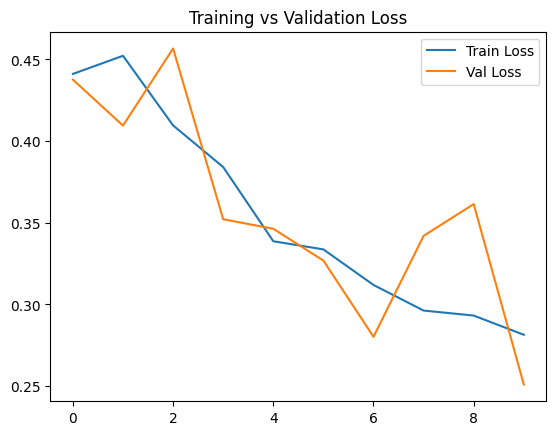

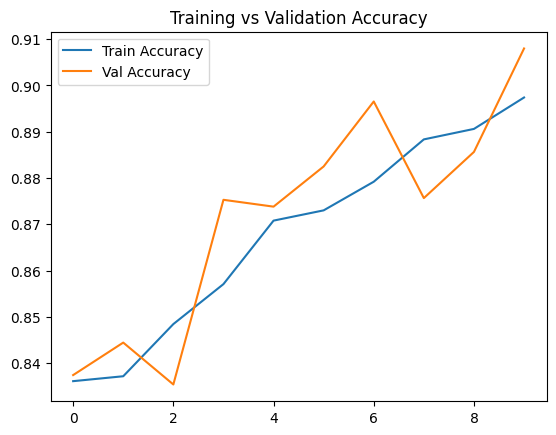

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


In [ ]:
# -------------------------
# 8) 평가 및 리포트
# -------------------------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"테스트 손실: {test_loss:.4f} | 테스트 정확도: {test_acc:.4f}")

y_pred_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\n분류 리포트")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("혼동행렬")
print(confusion_matrix(y_test, y_pred))

테스트 손실: 0.2402 | 테스트 정확도: 0.9161

분류 리포트
              precision    recall  f1-score   support

  Downstairs       0.74      0.56      0.64       622
     Jogging       0.98      0.98      0.98      2100
     Sitting       0.96      0.94      0.95       373
    Standing       0.93      0.99      0.96       297
    Upstairs       0.68      0.77      0.72       767
     Walking       0.97      0.98      0.97      2607

    accuracy                           0.92      6766
   macro avg       0.88      0.87      0.87      6766
weighted avg       0.92      0.92      0.91      6766

혼동행렬
[[ 347    4    6    3  227   35]
 [   3 2061    4    0   11   21]
 [   0    0  352   18    2    1]
 [   1    0    2  293    1    0]
 [ 110   35    3    1  594   24]
 [   8    7    1    0   40 2551]]
